In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
import PIL
PIL.__version__

'7.2.0'

Data Loading

In [3]:
images = []
genders = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

In [4]:
images = pd.Series(list(images), name = 'Images')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images,genders], axis=1)
df

,Images,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1
...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1


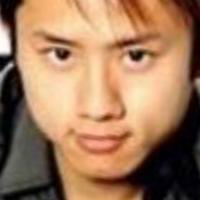

0


In [5]:
display(df['Images'][0])
print(df['Genders'][0])

Data Preprocessing


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Genders', ylabel='count'>

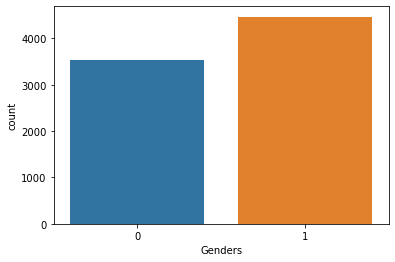

In [6]:
sns.countplot(df['Genders'])

Not sure what 3 corresponds to - both genders, no gender, unknown, or just an error in the data entry? To be safe, I am going to remove any rows where gender equals 3.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Genders', ylabel='count'>

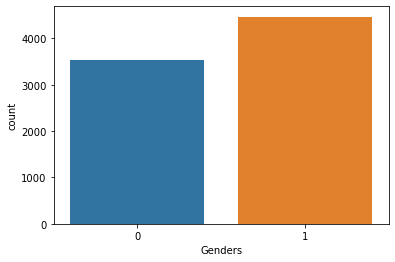

In [7]:
df = df[df['Genders'] != 3]
sns.countplot(df['Genders'])

In [8]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Train Test Split

In [9]:

y_gender = df['Genders']
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

Model Creation

In [10]:
genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

Model Training

In [11]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=50, shuffle=True, validation_data=test2)

Epoch 1/50
100/100 [==============================] - 51s 480ms/step - loss: 0.6795 - accuracy: 0.5640 - val_loss: 0.6160 - val_accuracy: 0.6463
Epoch 2/50
100/100 [==============================] - 48s 475ms/step - loss: 0.6304 - accuracy: 0.6309 - val_loss: 0.6008 - val_accuracy: 0.6650
Epoch 3/50
100/100 [==============================] - 47s 474ms/step - loss: 0.6048 - accuracy: 0.6686 - val_loss: 0.5719 - val_accuracy: 0.6925
Epoch 4/50
100/100 [==============================] - 48s 477ms/step - loss: 0.5943 - accuracy: 0.6724 - val_loss: 0.5463 - val_accuracy: 0.7163
Epoch 5/50
100/100 [==============================] - 47s 470ms/step - loss: 0.5757 - accuracy: 0.6963 - val_loss: 0.5363 - val_accuracy: 0.7369
Epoch 6/50
100/100 [==============================] - 48s 475ms/step - loss: 0.5677 - accuracy: 0.7009 - val_loss: 0.5145 - val_accuracy: 0.7400
Epoch 7/50
100/100 [==============================] - 47s 473ms/step - loss: 0.5525 - accuracy: 0.7079 - val_loss: 0.5038 - val_ac

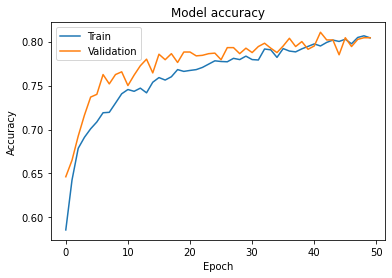

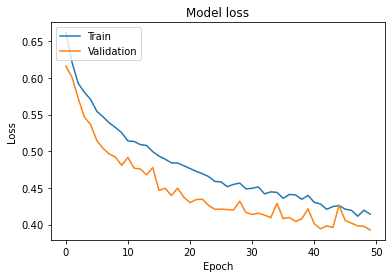

In [12]:
import matplotlib.pyplot as plt



# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [13]:
genmodel.save("gen_model_v4.h5")

Model Prediction

In [14]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)